# Two Metronome Model

## Required imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pandas import DataFrame

## Constants & Parameters

In [2]:
"""# Constants
g = 9.81                            # Gravity (m/s^2)

# Metronome Parameters
m_pendulum = 0.1                    # Mass of pendulum (kg)
L1_pendulum = 0.3                   # Length of first pendulum (m)
L2_pendulum = 0.3                   # Length of second pendulum (m)
epsilon = 0.15                      # Escapement force coefficient
theta1_0_init=theta1_0 = 0.9        # Initial position of metronome 1
theta2_0_init=theta2_0 = 0.25       # Initial position of metronome 2
I1 = m_pendulum * L1_pendulum**2    # Inertia of first pendulum
I2 = m_pendulum * L2_pendulum**2    # Inertia of second pendulum

# Surface Parameters (Coupling)
M_surface = 1.0                     # Mass of the surface (kg)
B_surface = 0.1                     # Surface damping coefficient
K_surface = 0.5                     # Surface stiffness

# Initial Conditions (Angles in radians)
omega1_0 = 0.0                      # Initial angular velocity
omega2_0 = 0.0                      # Initial angular velocity
x_0 = 0.0                           # Initial displacement of the surface
v_0 = 0.0                           # Initial velocity of the surface

# Cart Parameters
M_cart = 1.0                        # Mass of the cart (kg)
B_cart = 0.1                        # Damping coefficient
K_cart = 0.5                        # Stiffness of the cart"""

'# Constants\ng = 9.81                            # Gravity (m/s^2)\n\n# Metronome Parameters\nm_pendulum = 0.1                    # Mass of pendulum (kg)\nL1_pendulum = 0.3                   # Length of first pendulum (m)\nL2_pendulum = 0.3                   # Length of second pendulum (m)\nepsilon = 0.15                      # Escapement force coefficient\ntheta1_0_init=theta1_0 = 0.9        # Initial position of metronome 1\ntheta2_0_init=theta2_0 = 0.25       # Initial position of metronome 2\nI1 = m_pendulum * L1_pendulum**2    # Inertia of first pendulum\nI2 = m_pendulum * L2_pendulum**2    # Inertia of second pendulum\n\n# Surface Parameters (Coupling)\nM_surface = 1.0                     # Mass of the surface (kg)\nB_surface = 0.1                     # Surface damping coefficient\nK_surface = 0.5                     # Surface stiffness\n\n# Initial Conditions (Angles in radians)\nomega1_0 = 0.0                      # Initial angular velocity\nomega2_0 = 0.0                     

In [3]:
# Constants
g = 9.81                            # Gravity (m/s^2)

# Metronome Parameters
m_pendulum = 0.1                    # Mass of pendulum (kg)
L1_pendulum = 0.3                   # Length of first pendulum (m)
L2_pendulum = 0.3                   # Length of second pendulum (m)
epsilon = 0.15                      # Escapement force coefficient
theta1_0_init=theta1_0 = 0.9        # Initial position of metronome 1
theta2_0_init=theta2_0 = 0.25       # Initial position of metronome 2
I1 = m_pendulum * L1_pendulum**2    # Inertia of first pendulum
I2 = m_pendulum * L2_pendulum**2    # Inertia of second pendulum

# Surface Parameters (Coupling)
M_surface = 1.0                     # Mass of the surface (kg)
B_surface = 0                     # Surface damping coefficient
K_surface = 0.5                     # Surface stiffness

# Initial Conditions (Angles in radians)
omega1_0 = 0.0                      # Initial angular velocity
omega2_0 = 0.0                      # Initial angular velocity
x_0 = 0.0                           # Initial displacement of the surface
v_0 = 0.0                           # Initial velocity of the surface

# Cart Parameters
M_cart = 1.0                        # Mass of the cart (kg)
B_cart = 0                       # Damping coefficient
K_cart = 0.5                        # Stiffness of the cart

## Two metronome model

In [4]:
def metronome_matrix_system(t, y, kd, kp):
    # Unpack state variables
    theta1, omega1, theta2, omega2, x, v = y  

    # Mass Matrix M(q)
    M_q = np.array([
        [I1, 0, m_pendulum * L1_pendulum * np.cos(theta1)],
        [0, I2, m_pendulum * L2_pendulum * np.cos(theta2)],
        [m_pendulum * L1_pendulum * np.cos(theta1), m_pendulum * L2_pendulum * np.cos(theta2), M_cart + 2 * m_pendulum]
    ])

    # Coriolis and Damping Matrix C(q, q_dot)
    C_q_qdot = np.array([
        [epsilon * ((theta1 / theta1_0)**2 - 1) * m_pendulum*(L1_pendulum**2), 0, 0],
        [0, epsilon * ((theta2 / theta2_0)**2 - 1) *m_pendulum*(L2_pendulum**2) , 0],
        [m_pendulum * L1_pendulum * np.sin(theta1) * omega1, m_pendulum * L2_pendulum * np.sin(theta2) * omega2, 0]
    ])

    # Gravity Matrix G(q)
    G_q = np.array([
        [m_pendulum * g * L1_pendulum * np.sin(theta1)],
        [m_pendulum * g * L2_pendulum * np.sin(theta2)],
        [0]     # No gravitational force directly on the cart
    ])

    # Feedback Linearization Control: Track Metronome 1's motion
    kd1 = kd2 = kd3 = kd
    kp1 = kp2 = kp3 = kp
    Kp_FB = np.diag([kp1, kp2, kp3])    # proportional gain for feedback linearization
    Kd_FB = np.diag([kd1, kd2, kd3])    # derivative gain for feedback linearization

    q_d = [theta1 ,theta1,-theta1]      # displacement of metronome 1
    qq =[omega1,omega1,-omega1]         # velocity of metronome 1

    q_tilde = q_d - np.array([[theta1], [theta2], [x]])         # displacement error between cart and metronome
    q_tilde_dot = qq - np.array([[omega1], [omega2], [v]])      # velocity error between cart and metronome
    v_control = Kp_FB @  q_tilde+ Kd_FB @ q_tilde_dot

    # control law u
    tau_input = (M_q @ v_control + C_q_qdot @ np.array([[omega1], [omega2], [v]]) + G_q)[2, 0]  

    """
    this control law not zero even if kd = kp = 0
    there is then some control applied even with gains set to 0

    (this tau_input variable is set to 0 manually in the no-control model)
    """

    # outer control loop
    # Compute intermediate terms
    K1 = m_pendulum * L1_pendulum * np.cos(theta1) * (kp1*q_tilde[0]+kd1*q_tilde_dot[0])
    K2 = m_pendulum * L2_pendulum * np.cos(theta2) * (kp2*q_tilde[1]+kd2*q_tilde_dot[1])
    K3 = (M_cart + 2 * m_pendulum)  * (kp3*q_tilde[1]+kd3*q_tilde_dot[2])
    # Compute control input τ
    #tau_input = K1 + K2 + K3 - (m_pendulum * L1_pendulum * np.sin(theta1) * omega1**2) - (m_pendulum * L2_pendulum * np.sin(theta2) * omega2**2)
    
    Tau = np.array([[0],[0],[tau_input] ]) # External force on the cart 

    # Solve for accelerations: M(q) * q_ddot + C(q, q_dot) * q_dot + G(q)=Tau
    q_ddot = np.linalg.solve(M_q, (Tau - np.dot(C_q_qdot, np.array([[omega1], [omega2], [v]])) - G_q))

    return [omega1, q_ddot[0, 0], omega2, q_ddot[1, 0], v, q_ddot[2, 0]]

## Model solver

In [5]:
class solver():
    """
    solver object for the feedback linearisation control

    stores the feedback derivative gain, proportional gain and all results in the model
    """
    def __init__(self, kd, kp, T_max=50):
        """
        set up the solver with an input kd, kp and t_max
        """
        self.kd = kd
        self.kp = kp
        self.T_max = T_max

        # set up the attributes for the model object to fill
        self.time = []
        self.theta1 = []
        self.qdd1 = []
        self.theta2 = []
        self.qdd2 = []
        self.surface_x = []
        self.qdd3 = []

        self.sync_time = -1
        self.sync_threshold = -1
        self.energy_plot = []
        self.system_energy = -1

    def solve(self, dt=0.01):
        """
        solve the ode with scipy.integrate.solve_ivp(), retrieve the results and fill the model objects attributes

        Args:
            dt (float, optional): change in time for integrator. Defaults to 0.01.

        Returns:
            solver object: model object     # probably unnecessary tbh
        """
        t_span = (0, self.T_max)
        y0 = [theta1_0_init, omega1_0, theta2_0_init, omega2_0, x_0, v_0]
        t_eval = np.arange(0, self.T_max, dt)

        sol = solve_ivp(metronome_matrix_system, t_span, y0, args=[self.kd, self.kp], t_eval=t_eval, method="RK45")

        # Extract solutions
        self.time = sol.t                # time
        self.theta1 = sol.y[0]           # angle of metronome 1
        self.qdd1 = sol.y[1]             # acceleration of metronome 1
        self.theta2 = sol.y[2]           # angle of metronome 1
        self.qdd2 = sol.y[3]             # acceleration of metronome 2
        self.surface_x = sol.y[4]        # Surface displacement
        self.qdd3 = sol.y[5]             # acceleration of cart

        return self

    def find_sync_time(self, sync_threshold=1.0):
        """
        find the sync time for the metronomes to a set accuracy or lower - if accuracy cannot be 
        reached, reduce by 0.05 until an accuracy is reached. records both time and accuracy.

        sync is determined if the average value of the phase diff of the two metronomes for the prior 3 seconds
        are within the threshold synchronicity set. returns the value of 3 seconds ago where the sync began

        Args:
            sync_threshold (float, optional): sync threshold (0 - 1). Defaults to 1.0.

        Returns:
            floats: threshold, time to sync     
            # redundant since the model attributes are filled anyway, left for compatability with old code
        """
        sync = False
        while not sync:
            for t in range(300, len(self.time)):
                phase_diff = np.abs(self.theta1[t-300:t] - self.theta2[t-300:t])
                avg_sync = np.mean(1 - phase_diff)

                # adjust this to increase threshold for synchronicity
                if avg_sync >= sync_threshold:
                    #print(f"Synched at {self.time[t-300]} with synch {avg_sync}")
                    sync = True
                    self.sync_time = self.time[t-300]
                    self.sync_threshold = sync_threshold
                    return sync_threshold, self.time[t-300]
                
            sync_threshold -= 0.05

    def calc_energy(self):
        """
        calculate the energy of a flc system of two metronomes with given input kd and kp

        calculates the energy as a combination of kinetic of both metronomes and cart + gpe from
        both metronomes using standard formula / predefined formula

        Returns:
            _type_: model, sync time, total energy (array)
        """

        # calc kinetic energy of metronomes
        # ke = 1/2 * I * omega**2
        # I = m * L**2
        # so ke = 1/2 * m * L**2 * omega**2
        ke_1 = 1/2 * m_pendulum * L1_pendulum**2 * self.qdd1**2
        ke_2 = 1/2 * m_pendulum * L2_pendulum**2 * self.qdd2**2

        # calc kinetic energy of cart
        # ke = 1/2 * m * v**2
        ke_3 = 1/2 * M_cart * self.qdd3**2

        total_ke = ke_1 + ke_2 + ke_3

        # calc gpe of metronomes
        # gpe = m * g * h
        # h = L * cos (theta)abs(
        gpe_1 = m_pendulum * g * L1_pendulum * np.cos(self.theta1)
        gpe_2 = m_pendulum * g * L2_pendulum * np.cos(self.theta2)

        total_gpe = gpe_1 + gpe_2

        # total energy
        total_energy = total_ke + total_gpe

        self.energy_plot = total_energy
        self.system_energy = np.sum(np.abs(total_energy))

## Results

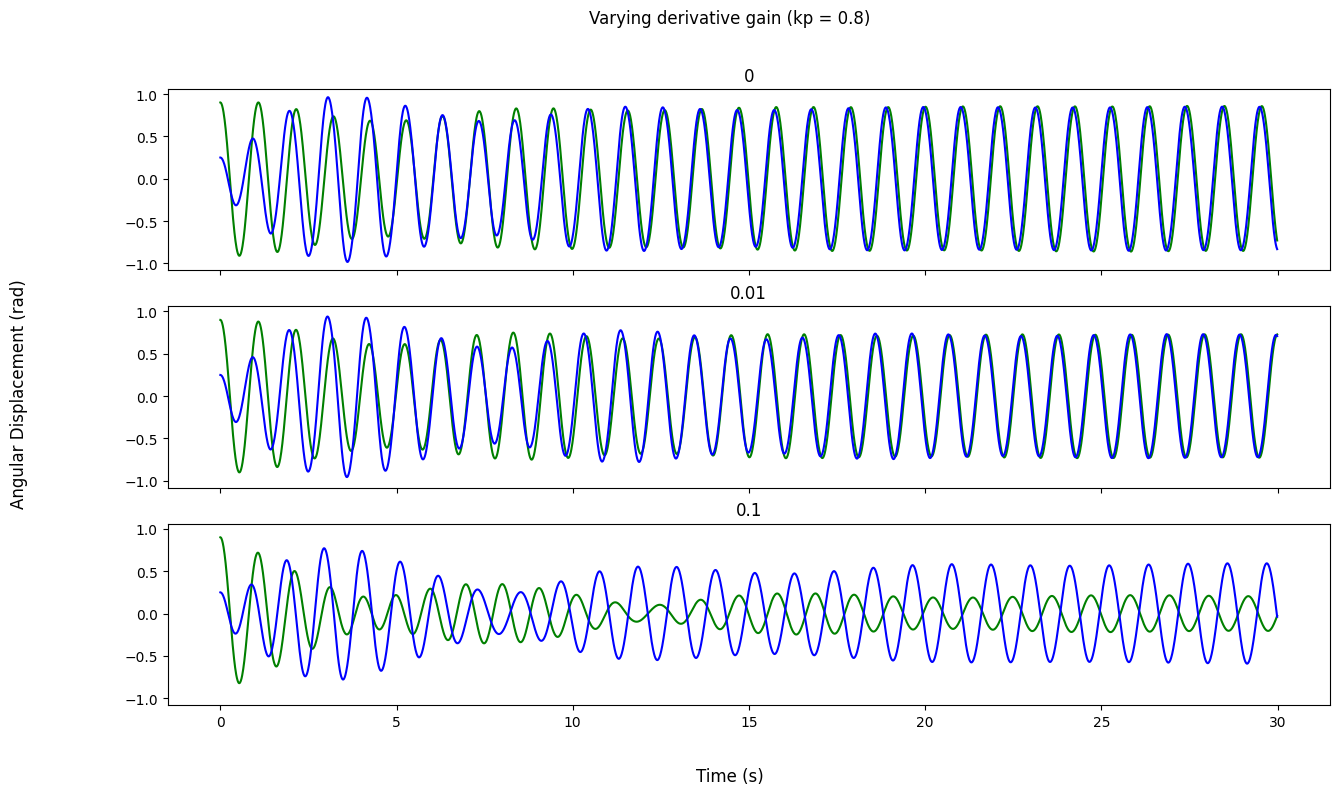

In [5]:
kp = 0.8
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(15, 8))
#plt.xlim(1,6)
fig1.supxlabel("Time (s)")
fig1.supylabel("Angular Displacement (rad)")
plt.suptitle(f"Varying derivative gain (kp = {kp})")
#plt.legend()
#plt.grid()

kds = [0, 0.01, 0.1]
for kd, ax in zip(kds, (ax1, ax2, ax3)):
    model = solver(kd, kp, 30)
    model.solve()
    ax.set_title(kd)
    ax.plot(model.time, model.theta1, label="Metronome 1", color='g')
    ax.plot(model.time, model.theta2, label="Metronome 2", color='b')
    #ax.legend()

plt.show()

# derivative gain of 0.1 results in complete antiphase, altho with much lower amplitude

* From this graph, observe that derivative gain $K_{d}$ is best in the range $0 - 0.1$

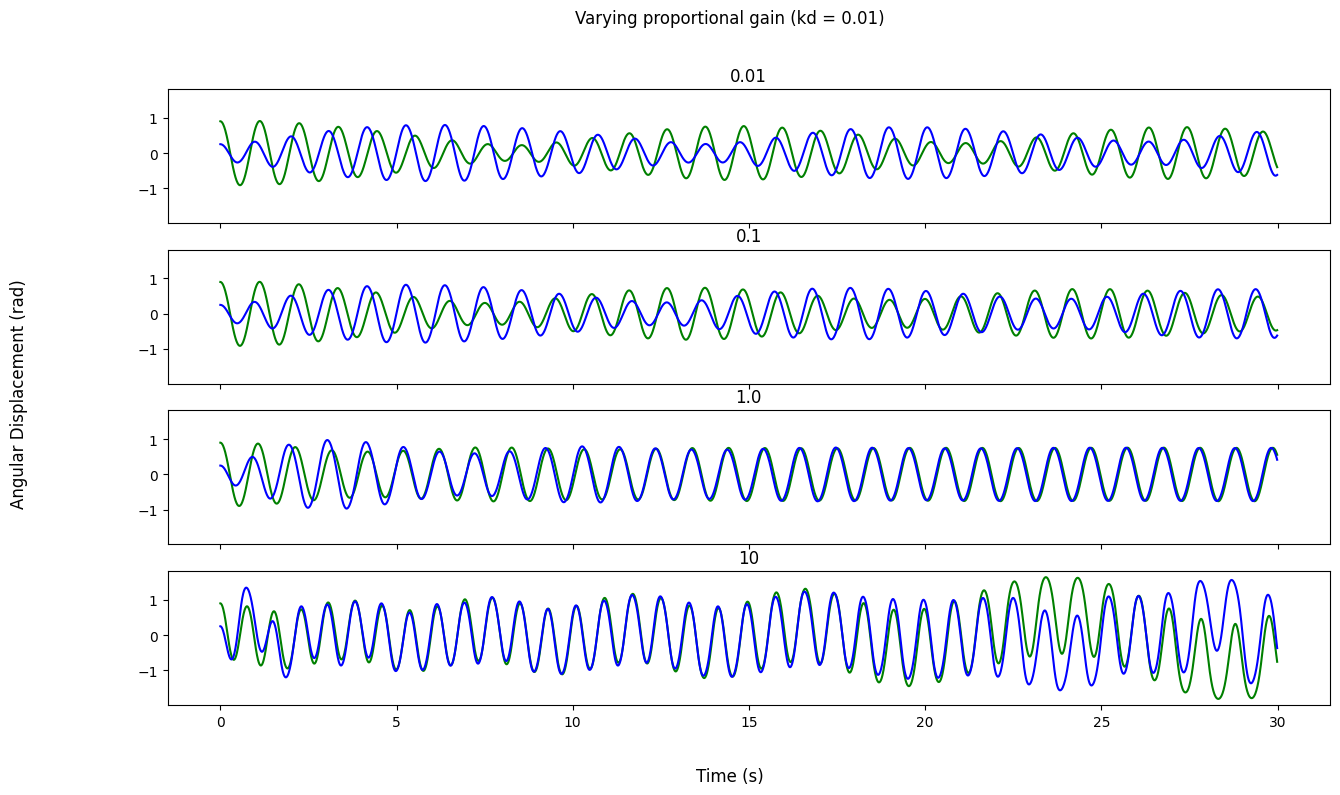

In [6]:
kd = 0.01
fig2, (ax4, ax5, ax6, ax7) = plt.subplots(4,1, sharex=True, sharey=True, figsize=(15, 8))
#plt.xlim(1,6)
fig2.supxlabel("Time (s)")
fig2.supylabel("Angular Displacement (rad)")
plt.suptitle(f"Varying proportional gain (kd = {kd})")
#plt.legend()
#plt.grid()

kps = [0.01, 0.1, 1.0, 10]
for kp, ax in zip(kps, (ax4, ax5, ax6, ax7)):
    model = solver(kd, kp, 30)
    model.solve()
    ax.set_title(kp)
    ax.plot(model.time, model.theta1, label="Metronome 1", color='g')
    ax.plot(model.time, model.theta2, label="Metronome 2", color='b')
    #ax.legend()

plt.show()

* From this graph, observe that proportional gain $K_{p}$ is best in the range $0.1 - 10$

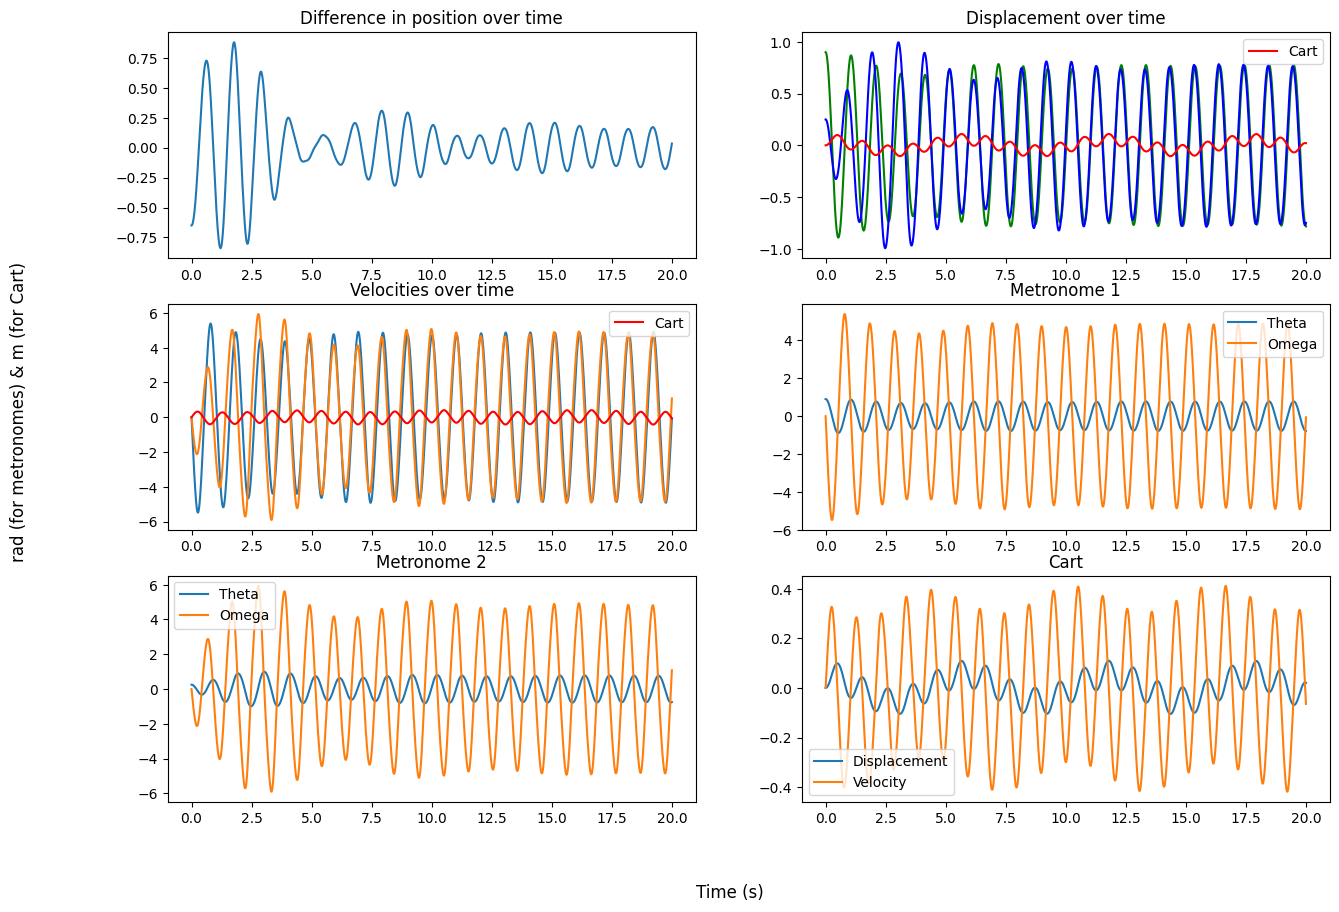

In [7]:
fig3, ax8 = plt.subplots(3,2, figsize=(15,10), squeeze=True)
model = solver(0.01, 1.2, 20)
model.solve()
ax8[0, 0].set_title("Difference in position over time")
ax8[0, 0].plot(model.time, (model.theta2 - model.theta1))
ax8[0, 1].set_title("Displacement over time")
ax8[0, 1].plot(model.time, model.theta1, c='g')
ax8[0, 1].plot(model.time, model.theta2, c='b')
ax8[0, 1].plot(model.time, model.surface_x, label="Cart", c="r")
ax8[0, 1].legend()
ax8[1, 0].set_title("Velocities over time")
ax8[1, 0].plot(model.time, model.qdd1)
ax8[1, 0].plot(model.time, model.qdd2)
ax8[1, 0].plot(model.time, model.qdd3, label="Cart", c="r")
ax8[1, 0].legend()
ax8[1, 1].set_title("Metronome 1")
ax8[1, 1].plot(model.time, model.theta1, label="Theta")
ax8[1, 1].plot(model.time, model.qdd1, label="Omega")
ax8[1, 1].legend()
ax8[2, 0].set_title("Metronome 2")
ax8[2, 0].plot(model.time, model.theta2, label="Theta")
ax8[2, 0].plot(model.time, model.qdd2, label="Omega")
ax8[2, 0].legend()
ax8[2, 1].set_title("Cart")
ax8[2, 1].plot(model.time, model.surface_x, label="Displacement")
ax8[2, 1].plot(model.time, model.qdd3, label="Velocity")
ax8[2, 1].legend()
fig3.supxlabel("Time (s)")
fig3.supylabel("rad (for metronomes) & m (for Cart)")
plt.show()

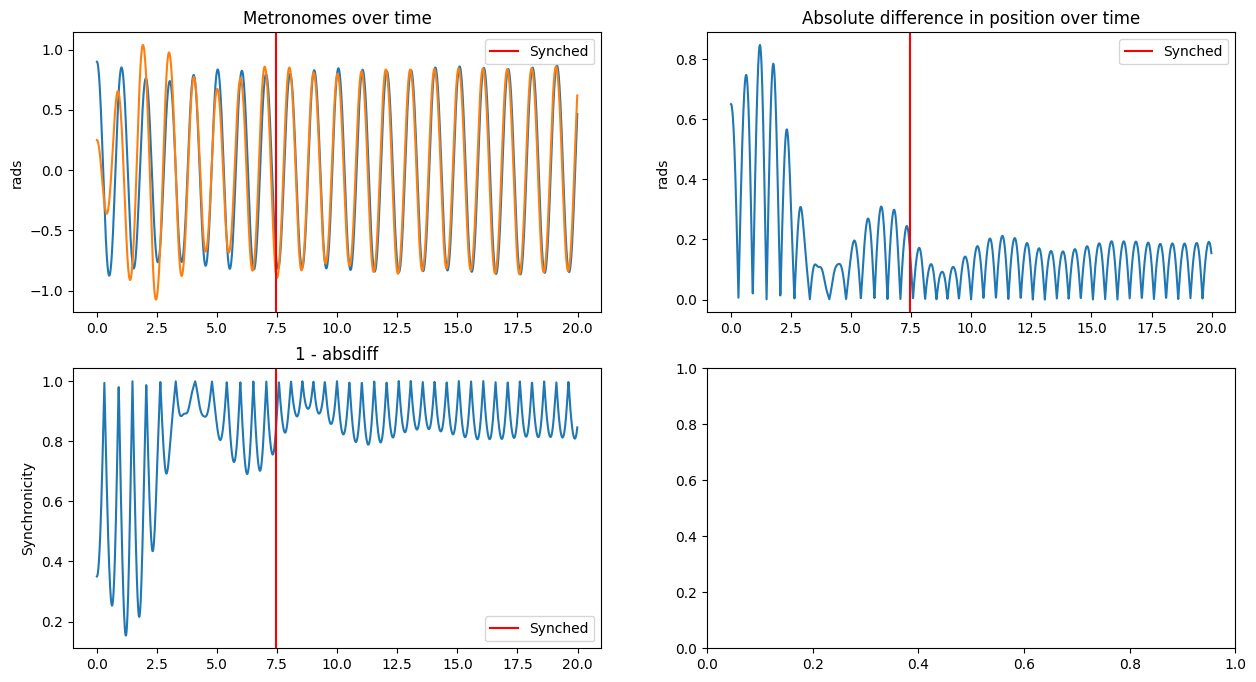

In [8]:
fig4, ax9 = plt.subplots(2, 2, figsize=(15,8))
model = solver(0.01, 1.9, 20)
model.solve()
sync_time = model.find_sync_time(sync_threshold=0.91)[1]

# plot
ax9[0, 0].set_title("Metronomes over time")
ax9[0, 0].set_ylabel("rads")
ax9[0, 0].plot(model.time, model.theta1)
ax9[0, 0].plot(model.time, model.theta2)
ax9[0, 0].axvline(sync_time, c="r", label="Synched")
ax9[0, 0].legend()

# measure 1 - position diff
ax9[0, 1].set_title("Absolute difference in position over time")
ax9[0, 1].set_ylabel("rads")
ax9[0, 1].plot(model.time, abs(model.theta1-model.theta2))
ax9[0, 1].axvline(sync_time, c="r", label="Synched")
ax9[0, 1].legend()

# measure 2 - synchronicity
ax9[1, 0].set_title("1 - absdiff")
ax9[1, 0].set_ylabel("Synchronicity")
ax9[1, 0].plot(model.time, 1 - abs(model.theta1-model.theta2))
ax9[1, 0].axvline(sync_time, c="r", label="Synched")
ax9[1, 0].legend()

# measure 3 - maybe something involving the velocity too, idrk

plt.show()

## Parameter Sweep

In [9]:
# Proportional gain improves tracking but may cause oscillations.
# Derivative gain reduces oscillations and improves damping.

# derivative gain
# this program is probably like O(n^4) or smth so keep num small
kds = np.linspace(0.0001, 0.1, 10)

# proportional gain
kps = np.linspace(0.1, 10, 10)

# results
results = []

for kd in kds:
    for kp in kps:
        model = solver(kd, kp)
        model.solve()
        thresh, sync_time = model.find_sync_time(1.0)
        results.append({"kd": kd, "kp": kp, "sync_thresh": thresh, "sync_time": sync_time})

# results df
data = DataFrame(results)
data.head(20)

,kd,kp,sync_thresh,sync_time
0,0.0001,0.1,0.95,20.18
1,0.0001,1.2,0.90,3.46
2,0.0001,2.3,0.85,1.81
3,0.0001,3.4,0.85,1.94
4,0.0001,4.5,0.85,1.36
5,0.0001,5.6,0.90,3.05
6,0.0001,6.7,0.90,3.14
7,0.0001,7.8,0.90,3.34
8,0.0001,8.9,0.90,3.47
9,0.0001,10.0,0.90,1.83


In [10]:
filtered_df = data[data['sync_thresh'] > 0.9]
filtered_df.head(20)

,kd,kp,sync_thresh,sync_time
0,0.0001,0.1,0.95,20.18
10,0.0112,0.1,0.95,41.26
21,0.0223,1.2,0.95,10.02
22,0.0223,2.3,0.95,10.56
23,0.0223,3.4,0.95,8.36
24,0.0223,4.5,0.95,7.10
25,0.0223,5.6,0.95,5.55
26,0.0223,6.7,0.95,6.57
27,0.0223,7.8,0.95,5.85
28,0.0223,8.9,0.95,5.58


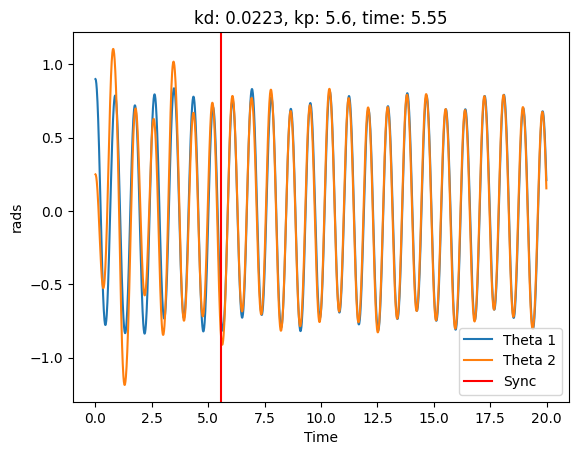

In [11]:
best = filtered_df.loc[filtered_df['sync_time'].idxmin()]

fig5, ax10 = plt.subplots()
model = solver(best["kd"], best["kp"], 20)
model.solve()

ax10.plot(model.time, model.theta1, label="Theta 1")
ax10.plot(model.time, model.theta2, label="Theta 2")
ax10.axvline(best["sync_time"], c="r", label = "Sync")
ax10.set_title(f"kd: {best["kd"]}, kp: {best["kp"]}, time: {best["sync_time"]}")
ax10.set_xlabel("Time")
ax10.set_ylabel("rads")
ax10.legend()

plt.show()

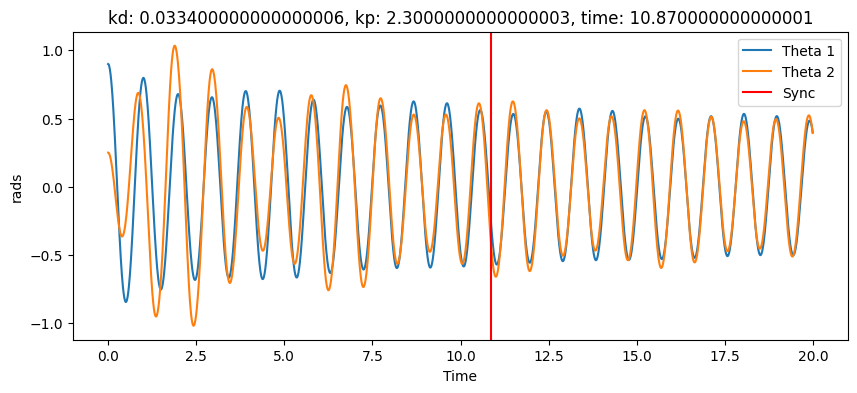

In [12]:
specific = filtered_df.loc[32]

fig5, ax11 = plt.subplots(figsize=(10,4))
model = solver(specific["kd"], specific["kp"], 20)
model.solve()

ax11.plot(model.time, model.theta1, label="Theta 1")
ax11.plot(model.time, model.theta2, label="Theta 2")
ax11.axvline(specific["sync_time"], c="r", label="Sync")
ax11.set_title(f"kd: {specific["kd"]}, kp: {specific["kp"]}, time: {specific["sync_time"]}")
ax11.set_xlabel("Time")
ax11.set_ylabel("rads")
ax11.legend()

plt.show()

## Energy

* measure energy with kinetic & gravitational formulas
* should oscillate

- the current program uses `scipy.integrate.solve_ivp()` to solve the ode
- this means that energy calcs can only rly be done per time step from the solution of the model

* referring to `Fig. 1.` in `Feedback.pdf`:
    * define positive theta as to the right of vertical
    * define positive x as cart moving to the right 
    * define $0$ gravitational potential as cart surface
    * define $ke = 0$ at $t=0$ 
    * assume metronome bob as point mass so $I = ml^{2}$

In [6]:
def calc_energy(solver, kd, kp, T_max=15):
    """
    calculate the energy of a flc system of two metronomes with given input kd and kp

    calculates the energy as a combination of kinetic of both metronomes and cart + gpe from
    both metronomes using standard formula / predefined formula

    Returns:
        _type_: model, sync time, total energy (array)
    """
    # set up a model and solve
    model = solver(kd, kp, T_max)
    model = model.solve()
    sync_time = model.find_sync_time()[1]

    # calc kinetic energy of metronomes
    # ke = 1/2 * I * omega**2
    # I = m * L**2
    # so ke = 1/2 * m * L**2 * omega**2
    ke_1 = 1/2 * m_pendulum * L1_pendulum**2 * model.theta1**2
    ke_2 = 1/2 * m_pendulum * L2_pendulum**2 * model.theta2**2

    # calc kinetic energy of cart
    # ke = 1/2 * m * v**2
    ke_3 = 1/2 * M_cart * model.qdd3**2

    total_ke = ke_1 + ke_2 + ke_3

    # calc gpe of metronomes
    # gpe = m * g * h
    # h = L * cos (theta)
    gpe_1 = m_pendulum * g * L1_pendulum * np.cos(model.theta1)
    gpe_2 = m_pendulum * g * L2_pendulum * np.cos(model.theta2)

    total_gpe = gpe_1 + gpe_2

    # total energy
    total_energy = total_ke + total_gpe

    # this should be rewritten as a function of the solver object with the energy as an attribute
    return model, sync_time, total_ke, total_gpe, total_energy

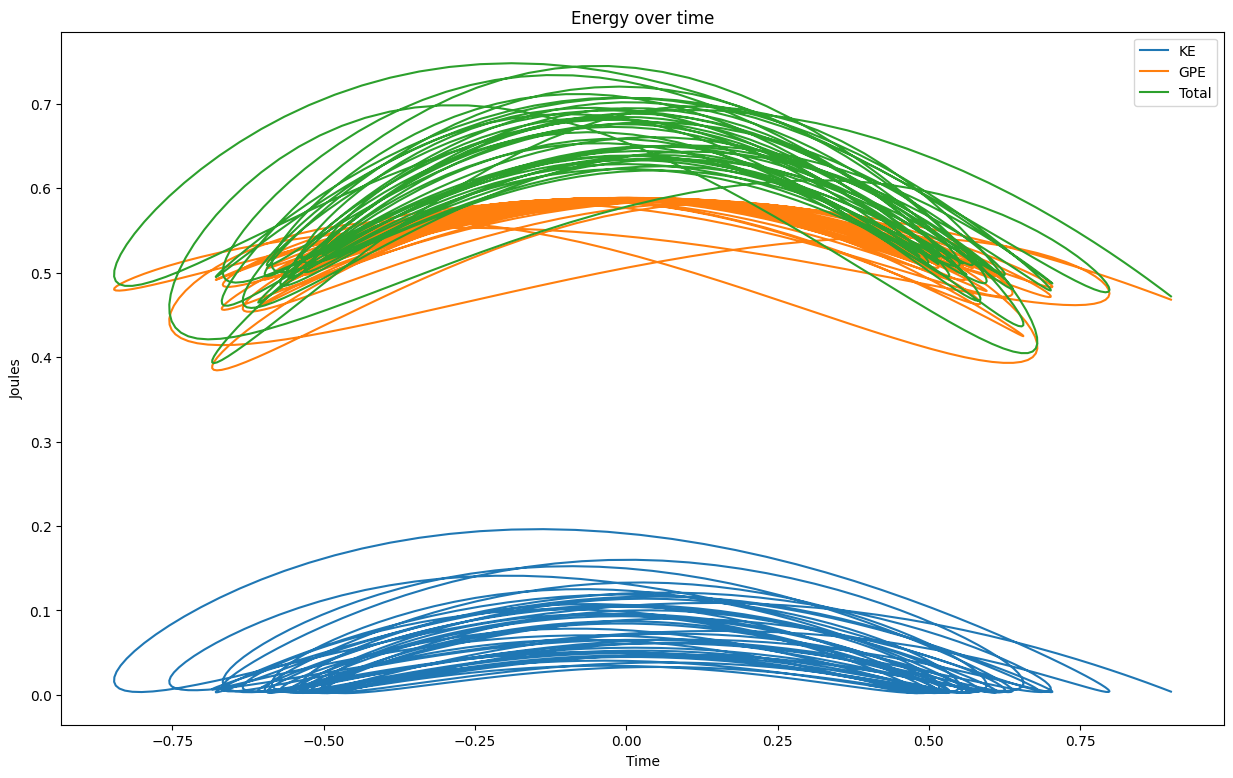

In [7]:
model, sync_time, total_ke, total_gpe, total_energy = calc_energy(solver, 0.0334, 2.3, 20)

# fig6, ax12 = plt.subplots(2,2, figsize=(15,9))
# ax12[0, 0].plot(model.time, model.theta1, label="Theta 1")
# ax12[0, 0].plot(model.time, model.theta2, label="Theta 2")
# ax12[0, 0].axvline(sync_time, c="r", label="Sync")
# ax12[0, 0].set_title(f"kd: {model.kd}, kp: {model.kp}, time: {model.sync_time}")
# ax12[0, 0].set_xlabel("Time")
# ax12[0, 0].set_ylabel("rads")
# ax12[0, 0].legend()

# ax12[0, 1].plot(model.time, total_ke, label="KE")
# ax12[0, 1].plot(model.time, total_gpe, label="GPE")
# ax12[0, 1].plot(model.time, total_energy, label="Total")
# ax12[0, 1].set_title(f"Energy over time")
# ax12[0, 1].set_xlabel("Time")
# ax12[0, 1].set_ylabel("Joules")
# ax12[0, 1].legend()

#model2, sync_time2, total_ke2, total_gpe2, total_energy2 = calc_energy(solver, 0.0223, 6.7, 20)
#
#ax12[1, 0].plot(model2.time, model2.theta1, label="Theta 1")
#ax12[1, 0].plot(model2.time, model2.theta2, label="Theta 2")
#ax12[1, 0].axvline(sync_time2, c="r", label="Sync")
#ax12[1, 0].set_title(f"kd: {model2.kd}, kp: {model2.kp}, time: {model2.sync_time}")
#ax12[1, 0].set_xlabel("Time")
#ax12[1, 0].set_ylabel("rads")
#ax12[1, 0].legend()
#
##ax12[1, 1].plot(model2.time, total_ke, label="KE")
##ax12[1, 1].plot(model2.time, total_gpe, label="GPE")
#ax12[1, 1].plot(model2.time, total_energy2, label="Total")
#ax12[1, 1].set_title(f"Energy over time")
#ax12[1, 1].set_xlabel("Time")
#ax12[1, 1].set_ylabel("Joules")
#ax12[1, 1].legend()
#
#plt.show()

fig, ax = plt.subplots(figsize=(15,9))
ax.plot(model.theta1, total_ke, label="KE")
ax.plot(model.theta1, total_gpe, label="GPE")
ax.plot(model.theta1, total_energy, label="Total")
ax.set_title(f"Energy over time")
ax.set_xlabel("Time")
ax.set_ylabel("Joules")
ax.legend()

In [15]:
# # mean energy difference between model2 and model1
# print(f"Mean energy difference: {np.mean(total_energy2 - total_energy)}")
# 
# print(f"Total energy with less control: {np.sum(np.abs(total_energy))}")
# print(f"Total energy with more control: {np.sum(np.abs(total_energy2))}")
# print(f"Energy diff: {np.sum(np.abs(total_energy2))- np.sum(np.abs(total_energy))}")

Mean energy difference: 0.2852109078217087
Total energy with less control: 1301.416625514124
Total energy with more control: 1871.8384411575412
Energy diff: 570.4218156434172


* More energy is required to decrease the sync time (as expected)

- Need comparison to no control as a control experiment

## No Control Model

In [8]:
def metronome_matrix_system2(t, y):
    # Unpack state variables
    theta1, omega1, theta2, omega2, x, v = y  

    # Mass Matrix M(q)
    M_q = np.array([
        [I1, 0, m_pendulum * L1_pendulum * np.cos(theta1)],
        [0, I2, m_pendulum * L2_pendulum * np.cos(theta2)],
        [m_pendulum * L1_pendulum * np.cos(theta1), m_pendulum * L2_pendulum * np.cos(theta2), M_cart + 2 * m_pendulum]
    ])

    # Coriolis and Damping Matrix C(q, q_dot)
    C_q_qdot = np.array([
        [epsilon * ((theta1 / theta1_0)**2 - 1) * m_pendulum*(L1_pendulum**2), 0, 0],
        [0, epsilon * ((theta2 / theta2_0)**2 - 1) *m_pendulum*(L2_pendulum**2) , 0],
        [m_pendulum * L1_pendulum * np.sin(theta1) * omega1, m_pendulum * L2_pendulum * np.sin(theta2) * omega2, 0]
    ])

    # Gravity Matrix G(q)
    G_q = np.array([
        [m_pendulum * g * L1_pendulum * np.sin(theta1)],
        [m_pendulum * g * L2_pendulum * np.sin(theta2)],
        [0]     # No gravitational force directly on the cart
    ])

    tau_input = 0  # No control applied
    
    Tau = np.array([[0],[0],[tau_input] ]) # External force on the cart 

    # Solve for accelerations: M(q) * q_ddot + C(q, q_dot) * q_dot + G(q)=Tau
    q_ddot = np.linalg.solve(M_q, (Tau - np.dot(C_q_qdot, np.array([[omega1], [omega2], [v]])) - G_q))

    return [omega1, q_ddot[0, 0], omega2, q_ddot[1, 0], v, q_ddot[2, 0]]

class solver_NC():
    def __init__(self, kd, kp, T_max=50):
        self.T_max = T_max

        self.time = []
        self.theta1 = []
        self.qdd1 = []
        self.theta2 = []
        self.qdd2 = []
        self.surface_x = []
        self.qdd3 = []

        self.sync_time = -1
        self.sync_threshold = -1

    def solve(self, dt=0.01):
        t_span = (0, self.T_max)
        y0 = [theta1_0_init, omega1_0, theta2_0_init, omega2_0, x_0, v_0]
        t_eval = np.arange(0, self.T_max, dt)

        sol = solve_ivp(metronome_matrix_system2, t_span, y0, t_eval=t_eval, method="DOP853")

        # Extract solutions
        self.time = sol.t                # time
        self.theta1 = sol.y[0]           # angle of metronome 1
        self.qdd1 = sol.y[1]             # velocity of metronome 1
        self.theta2 = sol.y[2]           # angle of metronome 1
        self.qdd2 = sol.y[3]             # velocity of metronome 2
        self.surface_x = sol.y[4]        # Surface displacement
        self.qdd3 = sol.y[5]             # acceleration of cart

        return self

    def find_sync_time(self, sync_threshold=1.0):
        sync = False
        while not sync:
            for t in range(300, len(self.time)):
                phase_diff = np.abs(self.theta1[t-300:t] - self.theta2[t-300:t])
                avg_sync = np.mean(1 - phase_diff)

                # adjust this to increase threshold for synchronicity
                if avg_sync >= sync_threshold:
                    #print(f"Synched at {self.time[t-300]} with synch {avg_sync}")
                    sync = True
                    self.sync_time = self.time[t-300]
                    self.sync_threshold = sync_threshold
                    return sync_threshold, self.time[t-300]
                
            sync_threshold -= 0.05

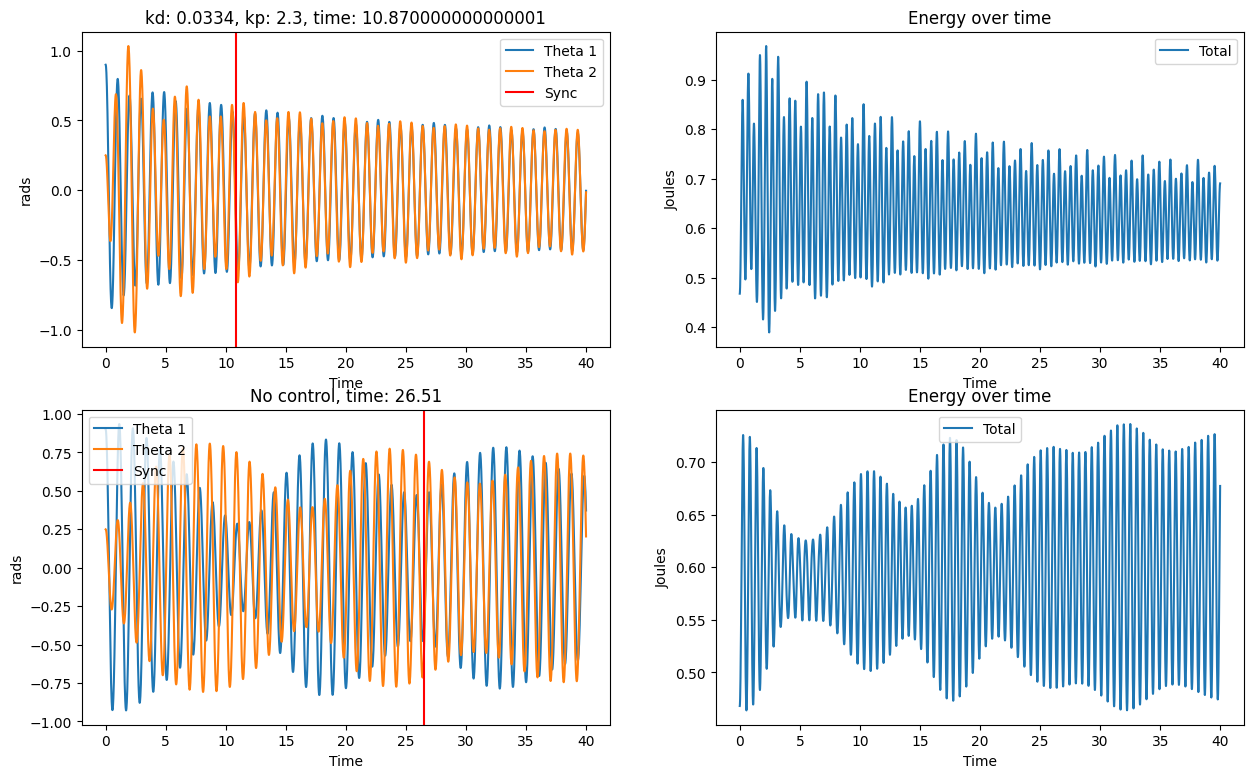

In [17]:
time = 40
model, sync_time, total_energy = calc_energy(solver, 0.0334, 2.3, time)

fig7, ax13 = plt.subplots(2,2, figsize=(15,9))
ax13[0, 0].plot(model.time, model.theta1, label="Theta 1")
ax13[0, 0].plot(model.time, model.theta2, label="Theta 2")
ax13[0, 0].axvline(sync_time, c="r", label="Sync")
ax13[0, 0].set_title(f"kd: {model.kd}, kp: {model.kp}, time: {model.sync_time}")
ax13[0, 0].set_xlabel("Time")
ax13[0, 0].set_ylabel("rads")
ax13[0, 0].legend()

#ax13[0, 1].plot(model.time, total_ke, label="KE")
#ax13[0, 1].plot(model.time, total_gpe, label="GPE")
ax13[0, 1].plot(model.time, total_energy, label="Total")
ax13[0, 1].set_title(f"Energy over time")
ax13[0, 1].set_xlabel("Time")
ax13[0, 1].set_ylabel("Joules")
ax13[0, 1].legend()

model2, sync_time2, total_energy2 = calc_energy(solver_NC, 0, 0, time)

ax13[1, 0].plot(model2.time, model2.theta1, label="Theta 1")
ax13[1, 0].plot(model2.time, model2.theta2, label="Theta 2")
ax13[1, 0].axvline(sync_time2, c="r", label="Sync")
ax13[1, 0].set_title(f"No control, time: {model2.sync_time}")
ax13[1, 0].set_xlabel("Time")
ax13[1, 0].set_ylabel("rads")
ax13[1, 0].legend()

#ax13[1, 1].plot(model2.time, total_ke, label="KE")
#ax13[1, 1].plot(model2.time, total_gpe, label="GPE")
ax13[1, 1].plot(model2.time, total_energy2, label="Total")
ax13[1, 1].set_title(f"Energy over time")
ax13[1, 1].set_xlabel("Time")
ax13[1, 1].set_ylabel("Joules")
ax13[1, 1].legend()

plt.show()

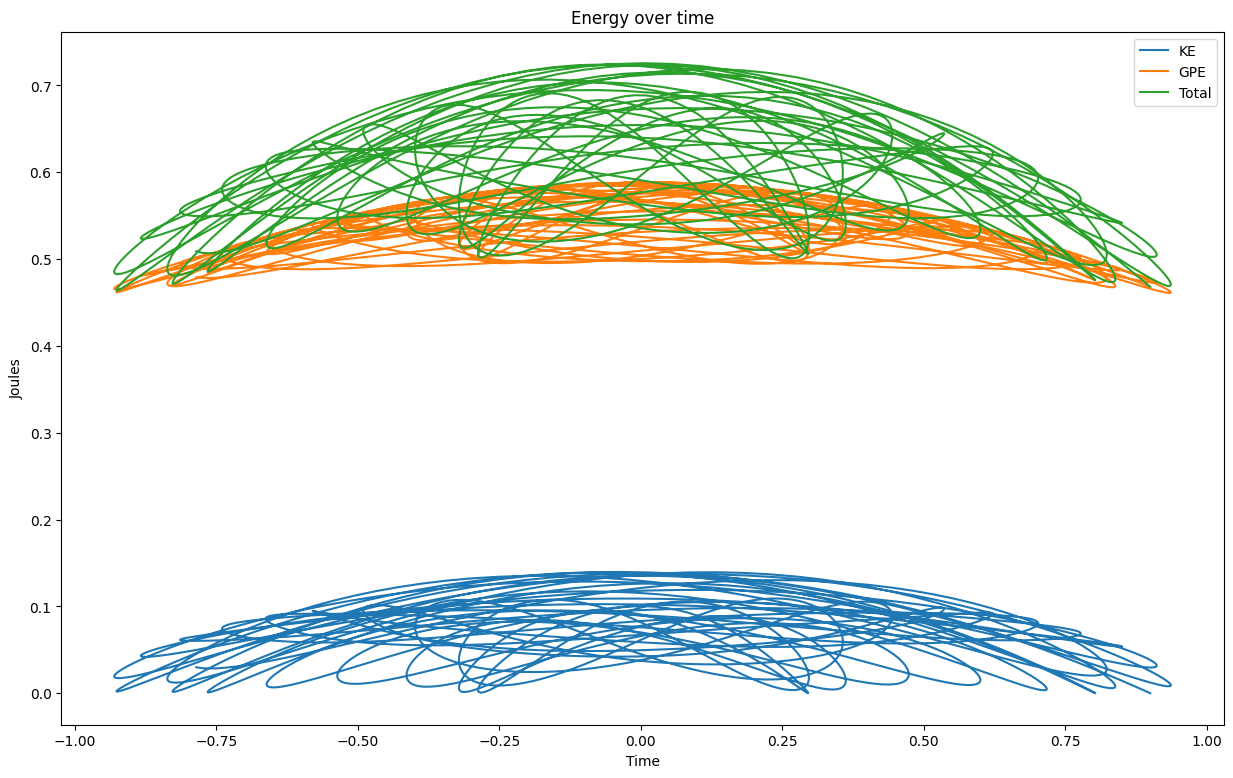

In [9]:
model, sync_time, total_ke, total_gpe, total_energy = calc_energy(solver_NC, 0, 0, 20)

fig, ax = plt.subplots(figsize=(15,9))
ax.plot(model.theta1, total_ke, label="KE")
ax.plot(model.theta1, total_gpe, label="GPE")
ax.plot(model.theta1, total_energy, label="Total")
ax.set_title(f"Energy over time")
ax.set_xlabel("Time")
ax.set_ylabel("Joules")
ax.legend()

In [18]:
# mean energy difference between model1 and model2
print(np.mean(total_energy - total_energy2))

print(f"Total energy with control: {np.sum(np.abs(total_energy))}")
print(f"Total energy with no control: {np.sum(np.abs(total_energy2))}")
print(f"Energy diff: {np.sum(np.abs(total_energy))- np.sum(np.abs(total_energy2))}")

0.04431236218494239
Total energy with control: 2558.629453423215
Total energy with no control: 2381.380004683446
Energy diff: 177.24944873976938


* Energy input for the control is calculated as `177.2` joules
* This speeds up the time to sync from `27s` to `11s` (-16s)

- It is shown that energy is required to apply the control - this is proportional to $K_{d}$ and $K_{p}$ 
constants put into the feedback linearisation control loop.

## Energy Input

In [19]:
time = 40

# control (no control applied)
base, base_sync_time, base_total_energy = calc_energy(solver_NC, 0, 0, time)
base_energy = np.sum(np.abs(base_total_energy))

# print(base_energy)
# 2381.380004683446

# 0kd, 0kp
A, A_sync_time, A_total_energy = calc_energy(solver, 0, 0, time)
A_energy = np.sum(np.abs(A_total_energy))
# print(A_energy)
# 2393.676132186879

print(A_energy - base_energy)

12.296127503432672


* applying the control needs ~12.3 joules without having derivative and proportional gains at all

These further values are drawn from the parameter sweep (at 95% synched metronomes) in reverse time order. Comments before the `calc_energy()` line are in the order: 

`kd` `kp` `sync_thresh` `sync_time`

In [20]:
# 0.0001	0.1	0.95	20.18
B, B_sync_time, B_total_energy = calc_energy(solver, 0.0001, 0.1, time)
B_energy = np.sum(np.abs(B_total_energy))
# print(B_energy)
# 2405.4624413861766

# 0.0445	5.6	0.95	13.32
C, C_sync_time, C_total_energy = calc_energy(solver, 0.0445, 5.6, time)
C_energy = np.sum(np.abs(C_total_energy))
# print(C_energy)
# 2738.9270960177773

# 0.0334	6.7	0.95	11.33
D, D_sync_time, D_total_energy = calc_energy(solver, 0.0334, 6.7, time)
D_energy = np.sum(np.abs(D_total_energy))
# print(D_energy)
# 3147.813358473428

# 0.0334	10.0	0.95	8.09
E, E_sync_time, E_total_energy = calc_energy(solver, 0.0334, 10.0, time)
E_energy = np.sum(np.abs(E_total_energy))
# print(E_energy)
# 3600.7471270575898

# 0.0223	4.5	0.95	7.10
F, F_sync_time, F_total_energy = calc_energy(solver, 0.0223, 4.5, time)
F_energy = np.sum(np.abs(F_total_energy))
# print(F_energy)
# 3138.2625353008816

# 	0.0223	7.8	0.95	5.85
G, G_sync_time, G_total_energy = calc_energy(solver, 0.0223, 7.8, time)
G_energy = np.sum(np.abs(G_total_energy))
# print(G_energy)
# 4014.5439201691743

# 	0.0223	5.6	0.95	5.55
H, H_sync_time, H_total_energy = calc_energy(solver, 0.0223, 5.6, time)
H_energy = np.sum(np.abs(H_total_energy))
# print(H_energy)
# 3422.3935140879103

* Results show the expected more energy in system -> faster sync time
* Some of the picked pairings of kd, kp result in better sync times despite being lower than other pairings

## Parameter Sweep 2

In [21]:
# Proportional gain improves tracking but may cause oscillations.
# Derivative gain reduces oscillations and improves damping.

# derivative gain
# this program is probably like O(n^4) or smth so keep num small
kds = np.linspace(0.0001, 0.1, 10)

# proportional gain
kps = np.linspace(0.1, 10, 10)

# results
results = []

# time
time = 40

for kd in kds:
    for kp in kps:
        # since calc_energy already makes and solves a model, only it needs to be called
        model, model_sync_time, model_total_energy = calc_energy(solver, kd, kp, time)
        
        # only record those which are deemed to be 95% synced for 3 seconds
        if model.sync_threshold > 0.9:
            model_energy = np.sum(np.abs(model_total_energy))
            results.append({"kd": kd, "kp": kp, "sync_time": model.sync_time, "energy of system": model_energy})

# results df, sorted by the sync time
data = DataFrame(results).sort_values("sync_time", ascending=False).reset_index(drop=True)
data.head(20)

,kd,kp,sync_time,energy of system
0,0.0001,0.1,20.18,2405.462441
1,0.0445,8.9,14.41,3037.589303
2,0.0445,5.6,13.32,2738.927096
3,0.0445,7.8,13.10,2933.339381
4,0.0334,6.7,11.33,3147.813358
5,0.0334,2.3,10.87,2558.629453
6,0.0223,2.3,10.56,2662.256294
7,0.0334,3.4,10.52,2686.291457
8,0.0223,1.2,10.02,2495.884725
9,0.0223,3.4,8.36,2880.167461


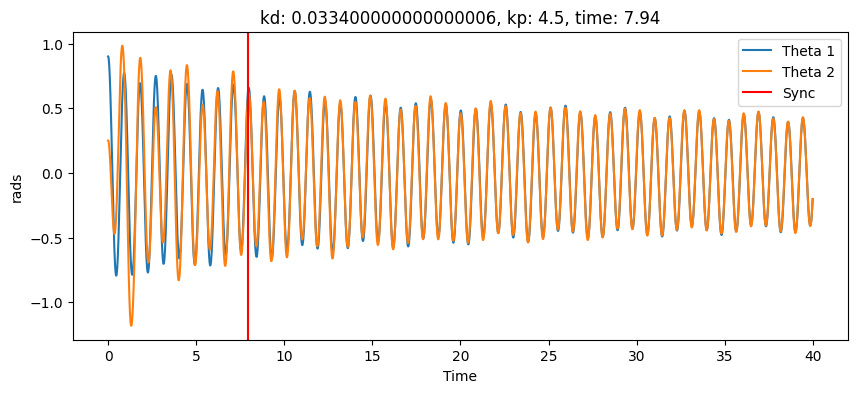

In [22]:
# visualise a specific index of the dataframe
specific = data.loc[11]

fig5, ax11 = plt.subplots(figsize=(10,4))
model = solver(specific["kd"], specific["kp"], time)
model.solve()

ax11.plot(model.time, model.theta1, label="Theta 1")
ax11.plot(model.time, model.theta2, label="Theta 2")
ax11.axvline(specific["sync_time"], c="r", label="Sync")
ax11.set_title(f"kd: {specific["kd"]}, kp: {specific["kp"]}, time: {specific["sync_time"]}")
ax11.set_xlabel("Time")
ax11.set_ylabel("rads")
ax11.legend()

plt.show()

* For the most part, increasing the values of $K_{d}$ & $K_{p}$ will require more energy input, but will reduce the time to sync as expected.
* There are some anomalies where lower values will result in faster syncing

### Notes

* All shown energies are `system total energy`
* Energy input can be found as `system total energy` $- 2381.380004683446$
* **The energy values are dependent on how long the model is run for (post sync system energy all normalise until energy discrepancies become negligible)**
* **All** the values stored are done with **40 seconds** of calculations - most 95% sync between 5 - 25 seconds
    * Might be better to swap to 30 seconds calculations for the energy

In [23]:
# Proportional gain improves tracking but may cause oscillations.
# Derivative gain reduces oscillations and improves damping.

# derivative gain
# this program is probably like O(n^4) or smth so keep num small
kds = np.linspace(0.0001, 0.1, 10)

# proportional gain
kps = np.linspace(0.1, 10, 10)

# results
results = []

# time
time = 30

for kd in kds:
    for kp in kps:
        # updated version of solver object code, now stores the system energy within the model
        model = solver(kd, kp, time)
        model.solve()
        model.find_sync_time()
        model.calc_energy()
        if model.sync_threshold > 0.9:
            results.append({"kd": kd, "kp": kp, "sync_time": model.sync_time, "energy of system": model.system_energy})

# results df, sorted by the sync time
data = DataFrame(results).sort_values("sync_time", ascending=False).reset_index(drop=True)
data.head(20)

,kd,kp,sync_time,energy of system
0,0.0001,0.1,20.18,1802.555814
1,0.0445,8.9,14.41,2375.075580
2,0.0445,5.6,13.32,2112.028325
3,0.0445,7.8,13.10,2287.666035
4,0.0334,6.7,11.33,2425.499106
5,0.0334,2.3,10.87,1933.628968
6,0.0223,2.3,10.56,2000.820566
7,0.0334,3.4,10.52,2040.615222
8,0.0223,1.2,10.02,1874.371702
9,0.0223,3.4,8.36,2170.857817


* 30 seconds of simulation & calculation shows the same overall trends, just smaller values for `system_energy`

- No current way to set input energy as a variable in the model
- Maybe do some model fitting for `sync time` $\alpha$ `energy input` based on more thorough results with specific $K_{d}$ & $K_{p}$ pairings?


## Fitted Predictor

From the previous program, take data for (input) energy and the resultant sync time. Fit a model to this data for a predictor for `sync time` $\alpha$ `energy input`. 

In [24]:
# no control model with time = 30
model = solver(0, 0, 30)
model.solve()
model.calc_energy()
print(model.system_energy)

1792.864395061677


In [5]:
# make dataset
# Proportional gain improves tracking but may cause oscillations.
# Derivative gain reduces oscillations and improves damping.

# derivative gain
# this program is probably like O(n^4) or smth so keep num small
kds = np.linspace(0.0001, 0.1, 30)

# proportional gain
kps = np.linspace(0.1, 10, 30)

# results
results = []

# time
time = 30

for kd in kds:
    for kp in kps:
        # updated version of solver object code, now stores the system energy within the model
        model = solver(kd, kp, time)
        model.solve()
        model.find_sync_time()
        model.calc_energy()

        input_energy = model.system_energy-1792.864395061677
        # lower threshold for more data, 85%+ is still a reasonable boundary
        if model.sync_threshold > 0.8 and input_energy < 5000:
            # change to energy input
            results.append({"kd": kd, "kp": kp, "sync_time": model.sync_time, "input_energy": 
                            input_energy})

# results df, sorted by the sync time
data = DataFrame(results).sort_values("sync_time", ascending=False).reset_index(drop=True)
data.head(20)

,kd,kp,sync_time,input_energy
0,0.024214,0.782759,26.12,40.559642
1,0.037993,2.148276,25.95,104.666202
2,0.020769,3.855172,25.59,478.855056
3,0.017324,0.441379,23.54,24.018106
4,0.013879,0.441379,23.15,29.328265
5,0.020769,0.441379,22.62,20.365650
6,0.000100,0.100000,20.18,9.691419
7,0.003545,0.100000,19.12,9.434955
8,0.020769,0.782759,18.76,46.884542
9,0.027659,0.782759,18.56,35.211843


In [18]:
# import required libraries
from scipy.optimize import curve_fit
from pandas import read_csv

In [20]:
# save the dataset to a csv so it doesnt have to be re-generated every time
# data.to_csv("energy_to_sync.csv")

# read in dataset
data = read_csv("energy_to_sync.csv")

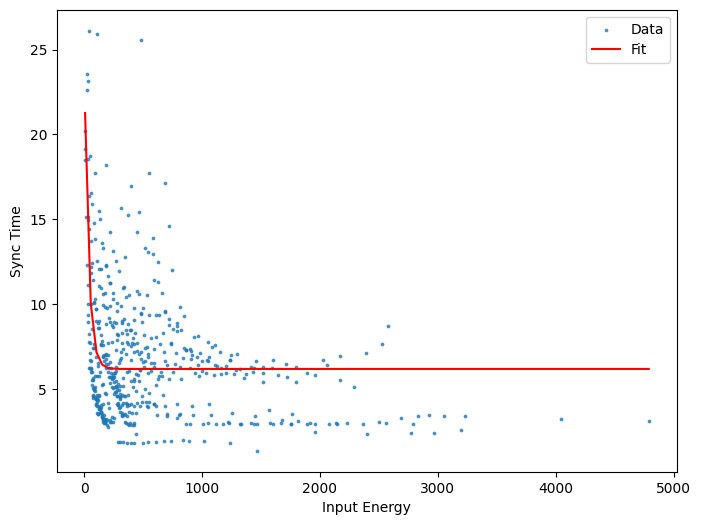

In [22]:
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def decay_func(x, a , b, c):
    return a ** x + b * x + c

def polynomial_frac(x, a, b, c, d):
    num = a * x
    den = b * x**3 + c
    return num/den + d

coefs, _ = curve_fit(exp_func, data["input_energy"], data["sync_time"])
#print(f"a: {coefs[0]}, b: {coefs[1]}, c: {coefs[2]}, d: {coefs[3]}")

x_fit = np.linspace(data["input_energy"].min(), data["input_energy"].max(), 100)
y_fit = exp_func(x_fit, *coefs)

plt.figure(figsize=(8, 6))
plt.scatter(data["input_energy"], data["sync_time"], alpha=0.7, label="Data", s=3)
plt.plot(x_fit, y_fit, color="red", label="Fit")
plt.xlabel("Input Energy")
plt.ylabel("Sync Time")
plt.legend()
plt.show()